In [1]:
# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
# ┃                                                           ┃
# ┃             Flight Simulator - RocketPy 1.0.0             ┃
# ┃                    VERSION 4 - 10.2023                    ┃
# ┃                                                           ┃
# ┃ Author:   Martin LEMAIRE - ERT FD co-TL                   ┃
# ┃ Contact:  martin.lemaire@epfl.ch                          ┃
# ┃                                                           ┃
# ┣━━━━━━━━━━━━━━━━━━━ Operation Procedure ━━━━━━━━━━━━━━━━━━━┫
# ┃                                                           ┃
# ┃  1. Place the .txt file of the thrust curve in the folder ┃
# ┃  2. Rename the .txt file to "thrust_curve.txt"            ┃
# ┃  3. Check all the data with the TODO Check                ┃
# ┃  4. Run All                                               ┃
# ┃                                                           ┃
# ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

**Imports**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from rocketpy import Environment, Rocket, Flight
from rocketpy.motors import LiquidMotor, CylindricalTank, Fluid
from rocketpy.motors.Tank import MassFlowRateBasedTank
import datetime, csv, shutil, math, os

**Functions definition**

In [3]:
def count_csv_rows(file_path):
    """
    Count the number of rows in a CSV file.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        int: The number of rows in the CSV file.

    If the file is not found or an error occurs, it returns 0.
    """
    try:
        with open(file_path, 'r') as csvfile:
            csvreader = csv.reader(csvfile)
            row_count = sum(1 for row in csvreader)
            return row_count
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return 0  # Return 0 if any errors occur

def write_arrays_to_csv(file_path, array1, array2, include_header=True):
    """
    Write two input arrays as two columns in a CSV file.

    Args:
        file_path (str): The path to the output CSV file.
        array1 (list): The first array to be written as the first column.
        array2 (list): The second array to be written as the second column.
        include_header (bool, optional): Whether to include a header row (default is True).

    Raises:
        ValueError: If input arrays have different lengths.

    """
    # Ensure both arrays have the same length
    if len(array1) != len(array2):
        raise ValueError("Input arrays must have the same length")

    # Open the CSV file for writing with error handling
    try:
        with open(file_path, 'w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)

            if include_header:
                # Write the header row
                csv_writer.writerow(['time', 'velocity'])

            # Write the data from the arrays
            for data1, data2 in zip(array1, array2):
                csv_writer.writerow([data1, data2])
    except IOError as e:
        print(f"Error writing to the CSV file: {e}")

def move_result(source_file, folder_name):
    """
    Move a file from a source path to a destination folder.

    Args:
        source_file (str): The path to the source file to be moved.
        folder_name (str): The name of the destination folder.

    This function attempts to move the source file to the specified destination folder.
    If the destination folder does not exist, it will be created. If the file is
    successfully moved, it prints a success message. If the source file is not found
    or an error occurs during the move operation, it prints an appropriate error message.
    """
    # Ensure the destination folder exists, creating it if necessary
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Define the destination path
    destination_path = os.path.join(folder_name, os.path.basename(source_file))

    try:
        # Move the file to the destination folder
        shutil.move(source_file, destination_path)
        print(f"{source_file} has been moved to {destination_path}.")
    except FileNotFoundError:
        print(f"Source file '{source_file}' not found.")
    except shutil.Error as e:
        print(f"Error while moving the file: {e}")

**Format the thrustcurve**

In [4]:
# Specify the input and output file names
input_file_name = "thrust_curve.txt"
# Check if the input string ends with ".txt"
if input_file_name.endswith(".txt"):
    # Remove the ".txt" extension and add "_no_ign.txt" instead
    output_file_name = input_file_name[:-4] + "_no_ign.txt"
else:
    # If the input string doesn't end with ".txt", just add "_no_ign.txt" to it
    output_file_name = input_file_name + "_no_ign.txt"

# Open the input file for reading and the output file for writing
with open(input_file_name, "r") as input_file, open(output_file_name, "w") as output_file:
    # Iterate through each line in the input file
    buf=0
    for line in input_file:
        # Split the line into columns using whitespace as the delimiter
        columns = line.strip().split()
        
        # Check if there are at least two columns (to ensure there is a second column)
        if len(columns) >= 2:
            try:
                # Convert the second column to an integer and check if it's greater than 500
                if float(columns[1]) > 100 and columns[0]!="motor":
                    # Write the line to the output file
                    output_file.write(line)
                    buf=1
                elif buf == 1 and float(columns[1]) > 100:
                    output_file.write(line)
            except ValueError:
                print("issue at this line : nothing written")# If the conversion to integer fails, skip the line
                pass

# Print a message to indicate the operation is complete
print("1 - Data under 100N at beginning removed\n")

txt_file_path = output_file_name
# Check if the input string ends with ".txt"
if txt_file_path.endswith("_no_ign.txt"):
    # Remove the ".txt" extension and add "_no_ign.txt" instead
    csv_file_path = txt_file_path[:-4] + ".csv"
else:
    # If the input string doesn't end with ".txt", just add "_no_ign.txt" to it
    csv_file_path = txt_file_path + ".csv"

# Open the TXT file for reading
with open(txt_file_path, 'r', encoding='utf-8-sig') as txt_file:
    # Open the CSV file for writing
    with open(csv_file_path, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file, delimiter=',')

        # Loop through each line in the TXT file
        for line in txt_file:
            # Split the line into fields based on spaces
            fields = line.strip().split(' ')

            # Write the fields to the CSV file
            csv_writer.writerow(fields)

print(f"2 - Transformation complete. CSV file saved as '{csv_file_path}'.")

#### COMMON ISSUE col[0],,col[2] => col[0],col[2] ####

# Open the input CSV file for reading and create a temporary file for writing
with open(csv_file_path, "r") as input_file, open("temp.csv", "w", newline='') as temp_file:
    # Create a CSV reader and writer
    csv_reader = csv.reader(input_file)
    csv_writer = csv.writer(temp_file)

    # Iterate through each row in the input CSV file
    for row in csv_reader:
        # Check if the row has at least 3 columns
        if len(row) >= 3:
            # Create a new row with only the first and third columns
            new_row = [row[0], row[2]]

            # Write the new row to the temporary CSV file
            csv_writer.writerow(new_row)
        else:
            csv_writer.writerow(row)

# Rename the temporary file to the original file name
os.rename("temp.csv", csv_file_path)

print("\n3 - CSV format checked")

1 - Data under 100N at beginning removed

2 - Transformation complete. CSV file saved as 'thrust_curve_no_ign.csv'.

3 - CSV format checked


**Usual Flight Parameters**

In [5]:
#━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
#This is where one can change usual flight parameters:
N2O_mass = 6.3144 #kg, liquid mass in tank #TODO CHECK
Eth_mass = 1.7971 #kg, liquid mass in tank #TODO CHECK
ND_dry_mass = 34.082 #kg, without engine, #TODO CHECK
days_to_launch_day = 1 #number of days until launch day, can be zero if today #TODO CHECK

#thrust_curve = "data/ThrustCurves/TC_motor_modif_euroc_extended_1800_no_ign.csv"
thrust_curve = csv_file_path
curve_burn_time = 9.3 #in seconds, careful if need to remove ignition #TODO CHECK
total_impulse = 14402 #Ns #TODO CHECK
#━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**Define Environment**

In [6]:
# Need weather forecast?? ("YES" or "NO")
weather_forecast = "NO" #TODO CHECK

#Defining the date at which we'll run the simulation
launch_day = datetime.date.today() + datetime.timedelta(days=days_to_launch_day)

#Defining an Environment for EuRoC
Env = Environment(
    #position of Santa Margarida military base
    latitude=39.389079, #TODO CHECK
    longitude=-8.288112, #TODO CHECK
    elevation=170, #TODO CHECK
    date = (launch_day.year, launch_day.month, launch_day.day, 12) # date in year, month, day, hour UTC format
    )

if weather_forecast=="YES":
    Env.set_atmospheric_model(type='Forecast', file='GFS')

**Add Motor**

In [7]:
#Create an engine ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Engine_dry_mass = 2.9 #kg #TODO CHECK
#Defining the Engine, tanks, pressurant, etc

#Defining propellants ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
 #TODO CHECK
oxidizer_liq = Fluid(name="N2O_l", density=900, quality=0.99) #N2O liquid at 0°C, from https://www.researchgate.net/figure/Thermodynamic-properties-of-liquid-nitrous-oxide-N2O_fig1_332489740
oxidizer_gas = Fluid(name="N2O_g", density=1.9277, quality=0.99) #TODO CHECK
fuel_liq = Fluid(name="ethanol_l", density=789, quality=0.99) #TODO CHECK
fuel_gas = Fluid(name="ethanol_g", density=1.59, quality=0.99) #TODO CHECK

#creating the engine ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
motor = LiquidMotor(
    coordinate_system_orientation = "nozzle_to_combustion_chamber",
    nozzle_radius = 48.86/1000, #Motor's nozzle outlet radius in meters, #TODO CHECK
    dry_mass=Engine_dry_mass, #kg, remove motor mass from total rocket mass, #TODO CHECK
    center_of_dry_mass=140/1000, #m, from nozzle, #TODO CHECK
    dry_inertia=(0, 0.14, 69.4/1000), #m, #TODO CHECK
    thrust_source = thrust_curve,
    reshape_thrust_curve = (curve_burn_time,total_impulse), #Need to reshape to have the correct timestep otherwise doesn't work. Need to compute the total impulse
    interpolation_method = 'linear', #Doesn't change that much
)

#First defining the tanks (Cylindrical for now), and putting them at the same place
 #TODO CHECK
Ox_Tank = CylindricalTank(74/1000, 479/1000, False) #695mm long, R1=43mm, R2=75mm, V=0.01228-0.004037=0.008243 --> transformed to have same volume
Fuel_Tank = CylindricalTank(35/1000, 700/1000, False) #Fuel Tank is 700mm long, 35mm radius, V=0.002694m3


#Defining oxidizer tank properties ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
oxidizer_tank = MassFlowRateBasedTank(
    name="oxidizer tank",
    geometry = Ox_Tank,
    flux_time=(0,motor.burn_time[1]), #Tank flux time in seconds. It is the time range in which the tank flux is being analyzed. In general, during this time, the tank is being filled or emptied.
    initial_liquid_mass=N2O_mass,
    initial_gas_mass=0, #in kg
    liquid_mass_flow_rate_in=0, #if it is replenished or whatever
    liquid_mass_flow_rate_out=int(N2O_mass/motor.burn_time[1]),
    gas_mass_flow_rate_in=0, #If it is pressurized (do not know if aacount for pressurant)
    gas_mass_flow_rate_out=0,
    liquid=oxidizer_liq, #liquid oxidizer info
    gas=oxidizer_gas #gas oxidizer info
)

#Defining fuel tank properties ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
fuel_tank = MassFlowRateBasedTank(
    name="fuel tank",
    geometry = Fuel_Tank,
    flux_time=(0,motor.burn_time[1]), ##Tank flux time in seconds. It is the time range in which the tank flux is being analyzed. In general, during this time, the tank is being filled or emptied.
    initial_liquid_mass=Eth_mass, #in kg
    initial_gas_mass=0, #in kg
    liquid_mass_flow_rate_in=0,
    liquid_mass_flow_rate_out=int(Eth_mass/motor.burn_time[1]),
    gas_mass_flow_rate_in=0,
    gas_mass_flow_rate_out=0,
    liquid=fuel_liq,
    gas=fuel_gas,
)

#Adding the tanks to the engine, second argument is position of tank wrt nozzle tip in meter
motor.add_tank(oxidizer_tank, 785/1000) #Position of the tanks in meters, from nozzle tip #TODO CHECK
motor.add_tank(fuel_tank, 785/1000) #TODO CHECK

**Information about the Motor**

Nozzle Details
Nozzle Radius: 0.04886 m

Motor Details
Total Burning Time: 9.3 s
Total Propellant Mass: 8.111 kg
Average Propellant Exhaust Velocity: inf m/s
Average Thrust: 1548.602 N
Maximum Thrust: 1985.4489493750693 N at 0.21593667546174145 s after ignition.
Total Impulse: 14402.000 Ns



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/rocketpy/Function.py:2178: RuntimeWarning: divide by zero encountered in double_scalars
  return Function(lambda x: (self.get_value_opt(x) / other(x)))


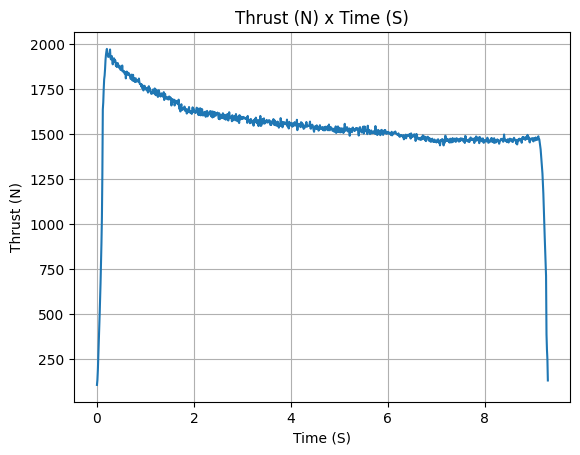

In [8]:
# Generate the plot using the library (replace with the appropriate code)
motor.info()

**Create the rocket**

In [9]:
ND_radius = 157/2000  #TODO CHECK
Nordend = Rocket(
    radius = ND_radius, 
    mass = ND_dry_mass, 
     #TODO CHECK
    inertia = (29.19, 29.19, 0.1234), #Tuple or list containing the rocket's dry mass inertia tensor components, in kg*m^2. Assuming e_3 is the rocket's axis of symmetry, e_1 and e_2 are orthogonal and form a plane perpendicular to e_3, the dry mass inertia tensor components must be given in the following order: (I_11, I_22, I_33, I_12, I_13, I_23), where I_ij is the component of the inertia tensor in the direction of e_i x e_j. Alternatively, the inertia tensor can be given as (I_11, I_22, I_33), where I_12 = I_13 = I_23 = 0.
    #TODO CHECK
    power_off_drag = 0.47, #Rocket's drag coefficient when the motor is off.  If int or float is given, it is assumed constant. If callable, string or array is given, it must be a function of Mach number only.
     #TODO CHECK
    power_on_drag = 0.48, #Rocket's drag coefficient when the motor is on. If int or float is given, it is assumed constant. If callable, string or array is given, it must be a function of Mach number only.
    coordinate_system_orientation = "nose_to_tail", #String defining the orientation of the rocket's coordinate system. The coordinate system is defined by the rocket's axis of symmetry. The system's origin may be placed anywhere along such axis and must be kept the same for all other positions specified.
    #Chose noseToTail to have same orientation as ORK #TODO CHECK
    center_of_mass_without_motor = 2.11, #Position, in m, of the rocket's center of dry mass (i.e. center of mass without propellant) relative to the rocket's coordinate system.
)

**Add Rail buttons**

In [10]:
Nordend.set_rail_buttons(
    upper_button_position=30/1000, #m from CoG without motor #TODO CHECK
    lower_button_position=1179/1000,#m #TODO CHECK
    angular_position=45, #TODO CHECK
    ) #Two values organized in a tuple, list or array which represent the position of each of the two rail buttons in the rocket coordinate system

**Add Motor**

In [11]:
Nordend.add_motor(motor, position=1040/1000) #m, position of engine wrt to Dry CoG #TODO CHECK

**Add Nosecone**

In [12]:
NoseCone = Nordend.add_nose(
    length=302/1000, #Nose cone length or height in meters. Must be a positive value. #TODO CHECK
    kind = "ogive", #Nose cone type. Von Karman, conical, ogive, and lvhaack are supported. #TODO CHECK
    position = 0/1000, #Nose cone tip coordinate relative to the rocket's coordinate system. #TODO CHECK
)

**Add Fins**

In [13]:
FinSet = Nordend.add_trapezoidal_fins(
    n = 4, #number of fins #TODO CHECK
    root_chord = 280/1000, #root chord in meters #TODO CHECK
    tip_chord = 125/1000, #Tip chord in meters #TODO CHECK
    span = 180/1000, #Span in meters (Height) #TODO CHECK
     #TODO CHECK
    position = 3300/1000, #Fin set position relative to the rocket's coordinate system. By fin set position, understand the point belonging to the root chord which is highest in the rocket coordinate system (i.e. generally the point closest to the nose cone tip).
     #TODO CHECK
    cant_angle = 0, #Fins cant angle with respect to the rocket centerline. Must be given in degrees.
    #sweep_length = 107/1000, #Fins sweep length in meters. By sweep length, understand the axial distance between the fin root leading edge and the fin tip leading edge measured parallel to the rocket centerline.
     #TODO CHECK
    sweep_angle = 30.7, #Fins sweep angle with respect to the rocket centerline. Must be given in degrees.
    radius = None, #Reference radius to calculate lift coefficient.
    airfoil = None, #Default is null, in which case fins will be treated as flat plates. Otherwise, if tuple, fins will be considered as airfoils.
)

**Add Boattail**

In [14]:
Boattail = Nordend.add_tail(
     #TODO CHECK
    top_radius = 157/2000, #Tail top radius in meters, considering positive direction from center of mass to nose cone.
     #TODO CHECK
    bottom_radius = 156.8/2000, #Tail bottom radius in meters, considering positive direction from center of mass to nose cone.
     #TODO CHECK
    length = 79/1000, #Tail length or height in meters. Must be a positive value.
     #TODO CHECK
    position = 3589/1000, #Position from coordinate system
)

**Add Parachutes**

In [15]:
# Main ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Main = Nordend.add_parachute(
    "releasedMain",
     #TODO CHECK
    cd_s = 10.0, #Drag coefficient times reference area for parachute. It is used to compute the drag force exerted on the parachute by the equation F = ((1/2)*rho*V^2)*CdS, that is, the drag force is the dynamic pressure computed on the parachute times its CdS coefficient. Has units of area and must be given in squared meters.
     #TODO CHECK
    trigger = 400, #meters AGL, Trigger for the parachute deployment. Can be a float with the height in which the parachute is ejected (ejction happens after apogee); or the string "apogee", for ejection at apogee.
     #TODO CHECK
    sampling_rate = 105, #Sampling rate in which the trigger function works. It is used to simulate the refresh rate of onboard sensors such as barometers.
     #TODO CHECK
    lag = 1.5, #Time between the parachute ejection system is triggered and the parachute is fully opened. During this time, the simulation will consider the rocket as flying without a parachute.
     #TODO CHECK
    noise = (0,0,0), #List in the format (mean, standard deviation, time-correlation). The values are used to add noise to the pressure signal which is passed to the trigger function.
)

# Drogue ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Drogue = Nordend.add_parachute(
    "reefedMain",
    cd_s = 1.0, #TODO CHECK
    trigger = "apogee", #TODO CHECK
    sampling_rate = 105, #TODO CHECK
    lag = 1.5, #TODO CHECK
    noise = (0,0,0), #TODO CHECK
)

**Run Simulation and export data**

In [16]:
# Running the simulation
EuRoC_Flight = Flight(
    rocket=Nordend, 
    environment=Env, 
    inclination=85,  #TODO CHECK
    heading=90, #TODO CHECK
    initial_solution=None, 
    terminate_on_apogee=False, 
    max_time=600, 
    max_time_step=10000000, 
    min_time_step=0, 
    rtol=1e-06, 
    atol=[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 1e-06, 1e-06, 1e-06, 1e-06, 0.001, 0.001, 0.001], 
    time_overshoot=True, 
    verbose=False,
    rail_length=12.0, #m #TODO CHECK
)

# ━━━━━ EXPORT DATA ━━━━━
csv_file = 'RPy_flight_ballistic.csv'
EuRoC_Flight.export_data(csv_file,'x','y','z','static_margin','vx','vy','vz','ax','ay','az')
# ━━━━━━━━━━━━━━━━━━━━━━━

**Information about the Flight**

In [17]:
EuRoC_Flight.info()


Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 170.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.706 | e1: -0.031 | e2: 0.031 | e3: -0.706
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: -90.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Surface Wind Conditions

Frontal Surface Wind Speed: 0.00 m/s
Lateral Surface Wind Speed: 0.00 m/s


Launch Rail

Launch Rail Length: 12.0  m
Launch Rail Inclination: 85.00°
Launch Rail Heading: 90.00°


Rail Departure State

Rail Departure Time: 0.918 s
Rail Departure Velocity: 25.624 m/s
Rail Departure Static Margin: 7.756 c
Rail Departure Angle of Attack: 0.000°
Rail Departure Thrust-Weight Ratio: 3.978
Rail Departure Reynolds Number: 2.716e+05


Burn out State

Burn out time: 9.300 s
Altitude at burn out: 1058.144 m (AGL)
Rocket velocity at burn out: 210.924 m/s
Freestream velocity at burn out: 210.924 m/s
Mach Number at burn out: 0.629
Kinetic energy at burn out

**Plot 3D trajectory**

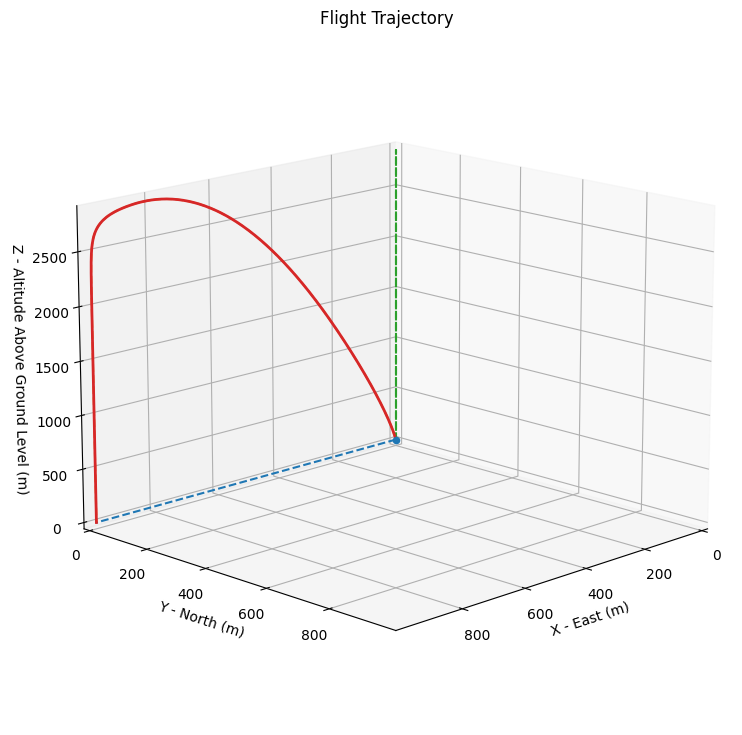

In [18]:
#TODO SAVE at "report_images/3D_trajectory.png"
EuRoC_Flight.plots.trajectory_3d()

**Plot Acceleration**

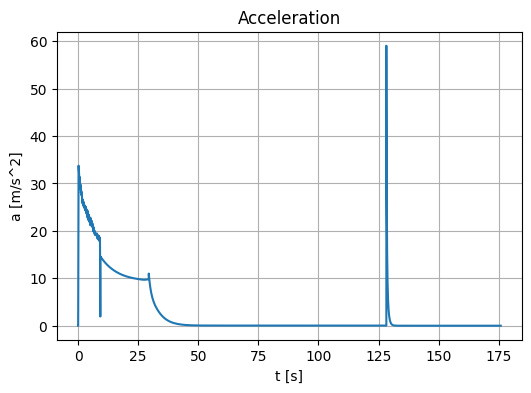

In [19]:
# Compute acceleration
data = pd.read_csv(csv_file)
time = []
acceleration = []
offset = 0
for i in range (int(count_csv_rows("RPy_flight_ballistic.csv"))-1):
    time.append(data["# Time (s)"][i+offset])
    acceleration.append(math.sqrt(pow(data[" Ax (m/s²)"][i+offset],2)+pow(data[" Ay (m/s²)"][i+offset],2)+pow(data[" Az (m/s²)"][i+offset],2)))
write_arrays_to_csv("data.csv",time,acceleration)

# ━━━━━ PLOT ACCELERATION ━━━━━
df = pd.read_csv("data.csv")
plt.figure(figsize=(6, 4))
plt.plot(df["time"],df["velocity"])
plt.xlabel('t [s]')
plt.ylabel('a [m/s^2]')
plt.title("Acceleration")
plt.grid(True)
plt.savefig("report_images/acceleration.png")
plt.show()
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**Plot Velocity**

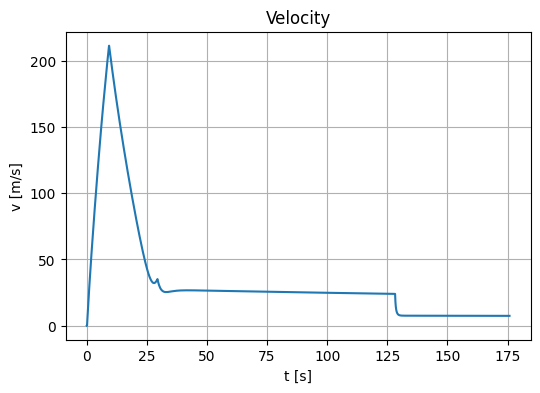

In [20]:
# Compute velocity
data = pd.read_csv("RPy_flight_ballistic.csv")
time = []
velocity = []
for i in range (int(count_csv_rows("RPy_flight_ballistic.csv"))-1):
    time.append(data["# Time (s)"][i]) 
    velocity.append(math.sqrt(pow(data[" Vx (m/s)"][i],2)+pow(data[" Vy (m/s)"][i],2)+pow(data[" Vz (m/s)"][i],2)))
write_arrays_to_csv("data.csv",time,velocity)

# ━━━━━   PLOT VELOCITY   ━━━━━
df = pd.read_csv("data.csv")
plt.figure(figsize=(6, 4))
plt.plot(df["time"],df["velocity"])
plt.xlabel('t [s]')
plt.ylabel('v [m/s]')
plt.title("Velocity")
plt.grid(True)
plt.savefig("report_images/velocity.png")
plt.show()
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**Plot Altitude AGL**

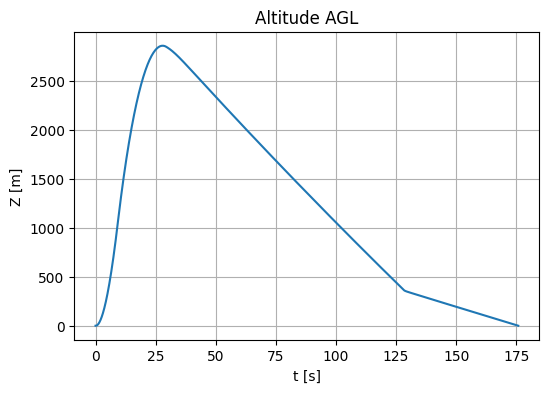

In [21]:
# Convert ASL Altitude to AGL Altitude
data = pd.read_csv("RPy_flight_ballistic.csv")
data[" Z (m)"] = data[" Z (m)"] - data[" Z (m)"][0]
data.to_csv("data.csv", index=False)

# ━━━━━ PLOT ALTITUDE AGL ━━━━━
df = pd.read_csv("data.csv")
plt.figure(figsize=(6, 4))
plt.plot(df["# Time (s)"],df[" Z (m)"])
plt.xlabel('t [s]')
plt.ylabel('Z [m]')
plt.title("Altitude AGL")
plt.grid(True)
plt.savefig("report_images/altitude.png")
plt.show()
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**Export Google Earth File**

In [22]:
EuRoC_Flight.export_kml("trajectory.kml")

File  trajectory.kml  saved with success!


**Clean the folder**

In [23]:
folder_name = "results"

# Check if the folder exists
if os.path.exists(folder_name) and os.path.isdir(folder_name):
    # Remove the folder and its contents
    for root, dirs, files in os.walk(folder_name, topdown=False):
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            os.rmdir(dir_path)
    os.rmdir(folder_name)

# Recreate the empty folder
os.mkdir(folder_name)

os.remove(csv_file_path)
os.remove(output_file_name)
os.remove("data.csv")

move_result("trajectory.kml","results")
move_result("RPy_flight_ballistic.csv","results")

trajectory.kml has been moved to results/trajectory.kml.
RPy_flight_ballistic.csv has been moved to results/RPy_flight_ballistic.csv.
